# Title
The purpose of this interactive notebook is to demonstrate how plagerism can be detected, using modern programming libraries.

TODO: explain python and spacy.io

## Data
TODO: explain the data we are using. Mention that this is not new data, the results were hinted at from a few sources. Also mention that in both documents, as they were copied from google docs, included the ligature spelling "Cæsar", which I replaced with "Caesar" manually.

In [1]:
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_lg")

# load the text
egw = open("data/egw.txt", "r")
doc_egw = nlp(egw.read())
egw.close()

mel = open("data/melvill.txt", "r")
doc_mel = nlp(mel.read())
mel.close()

## First approach: compare documents in their entirety
Each document is first tokenized. Then for each document, the average vector of all vectorizable tokens is computed. The similarity of the two documents is measured by the difference of angle between the two averaged vectors. Difference of the angles is calculated using the "cosine difference":

$$ similarity(x, y) = \cos \theta  = \frac{x\cdot y}{\|x\|\|y\|} $$

[More info](https://www.sciencedirect.com/topics/computer-science/cosine-similarity)

Note that this measure is not really suitable for detecting plagerized text. It's more suited for quickly finding the top search results from a body of text given search terms.

In [2]:
doc_egw.similarity(doc_mel)

0.9950424790621917

This value, although close to 1, doesn't give us much information on how the two documents are similar. It's an average measure, and it doesn't tell us which parts of the two documents are more similar to each other than others.

## Second approach: pairwise sentence comparison
It is easy to check that similar sentences have high similarity scores. Consider the following pair of sentences, one from each document:

In [3]:
a = list(doc_egw.sents)[92]
print(a)

Few religious privileges are granted them; and should they manifest an interest in religion, they might lose the favor of their employer, and bring upon themselves the ridicule of their companions.


In [4]:
b = list(doc_mel.sents)[112]
print(b)

If inclined to give heed to religion, they cannot but perceive that any indication of piety would perhaps lose them the favor of their master, and bring upon them the ridicule of their associates.


In [5]:
a.similarity(b)

0.9391828179359436

By running pairwise comparison of the sentences from the two documents, we might be able to detect which, if any, sentences have been plagerized.

/var/folders/6h/4544kbh53s76rw63mxtngdmc0000gn/T/ipykernel_32162/920695216.py:9: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  Data[i].append(a.similarity(b))


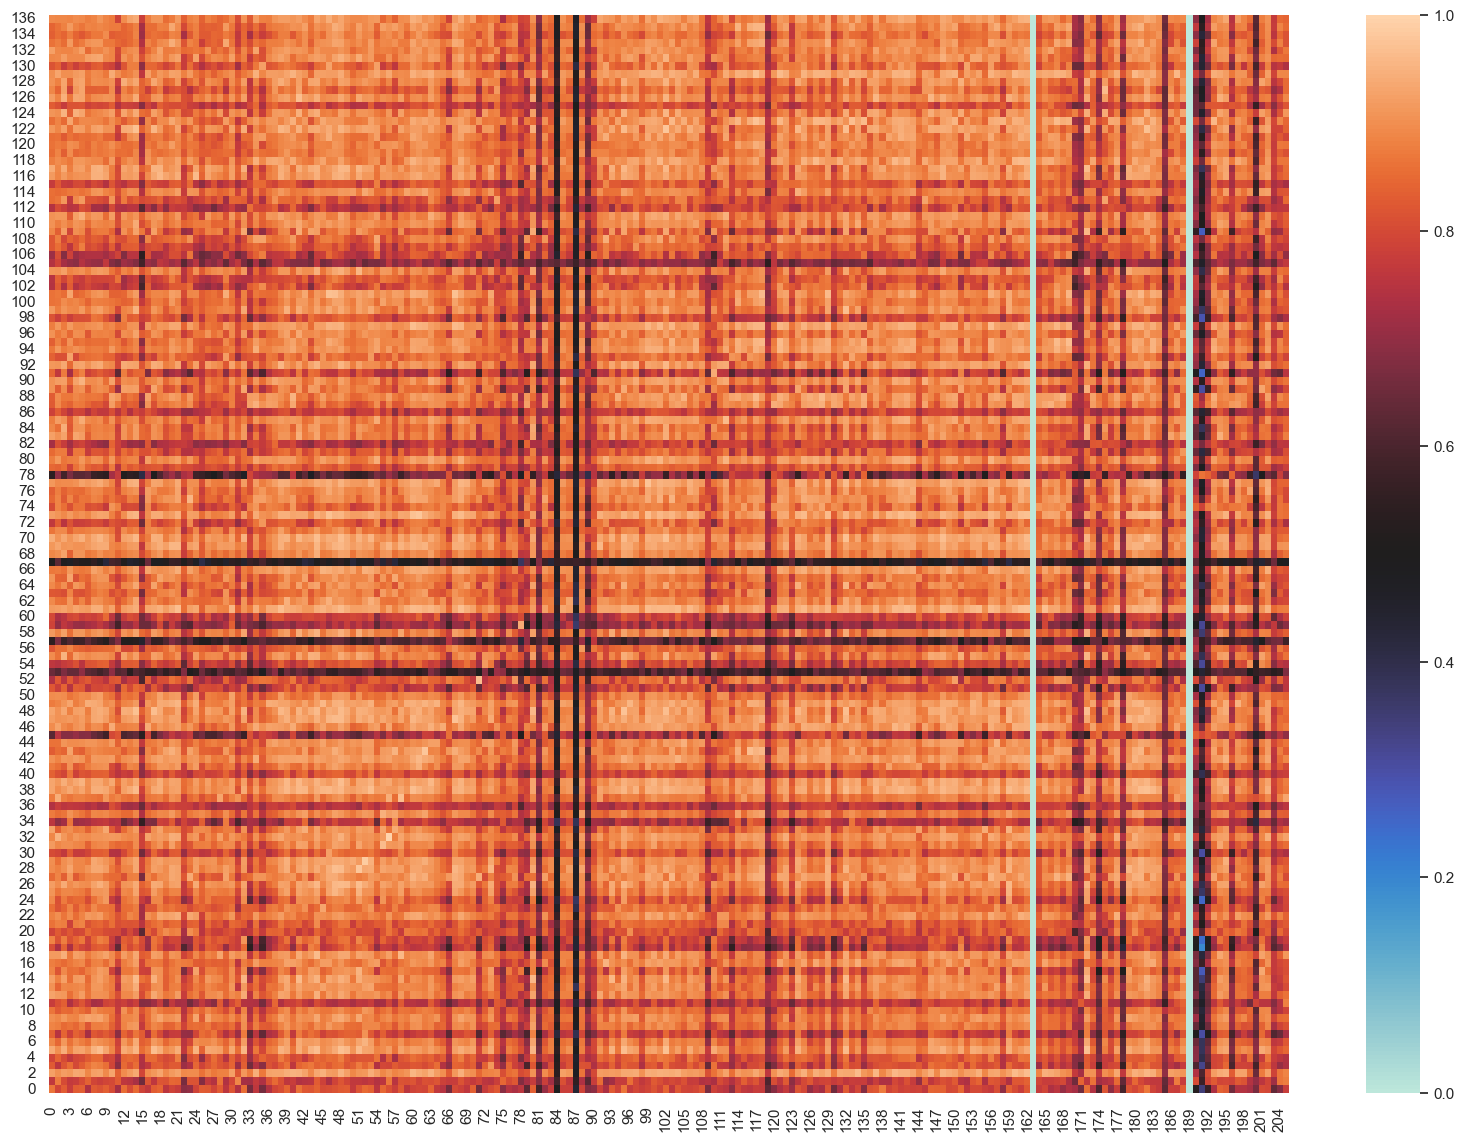

In [6]:
Data = []

# pairwise compare each sentence, populating the array with the scores
for i, a in enumerate(doc_egw.sents):
    
    Data.append([])
    
    for j, b in enumerate(doc_mel.sents):
        Data[i].append(a.similarity(b))
        
# create a heatmap from the data
sns.set(rc = {'figure.figsize':(20,14)})
heatmap = sns.heatmap(data=Data, center=0.5, vmin=0, vmax=1)
heatmap.invert_yaxis()

There is a barely perceptible lighter diagonal line running from the lower left to the upper right. Most of the scores already look to be greater than 0.75, making it difficult to find the sentences that have scores greater than 0.9.

Indeed, if we examine the distribution of the values:

<AxesSubplot: ylabel='Count'>

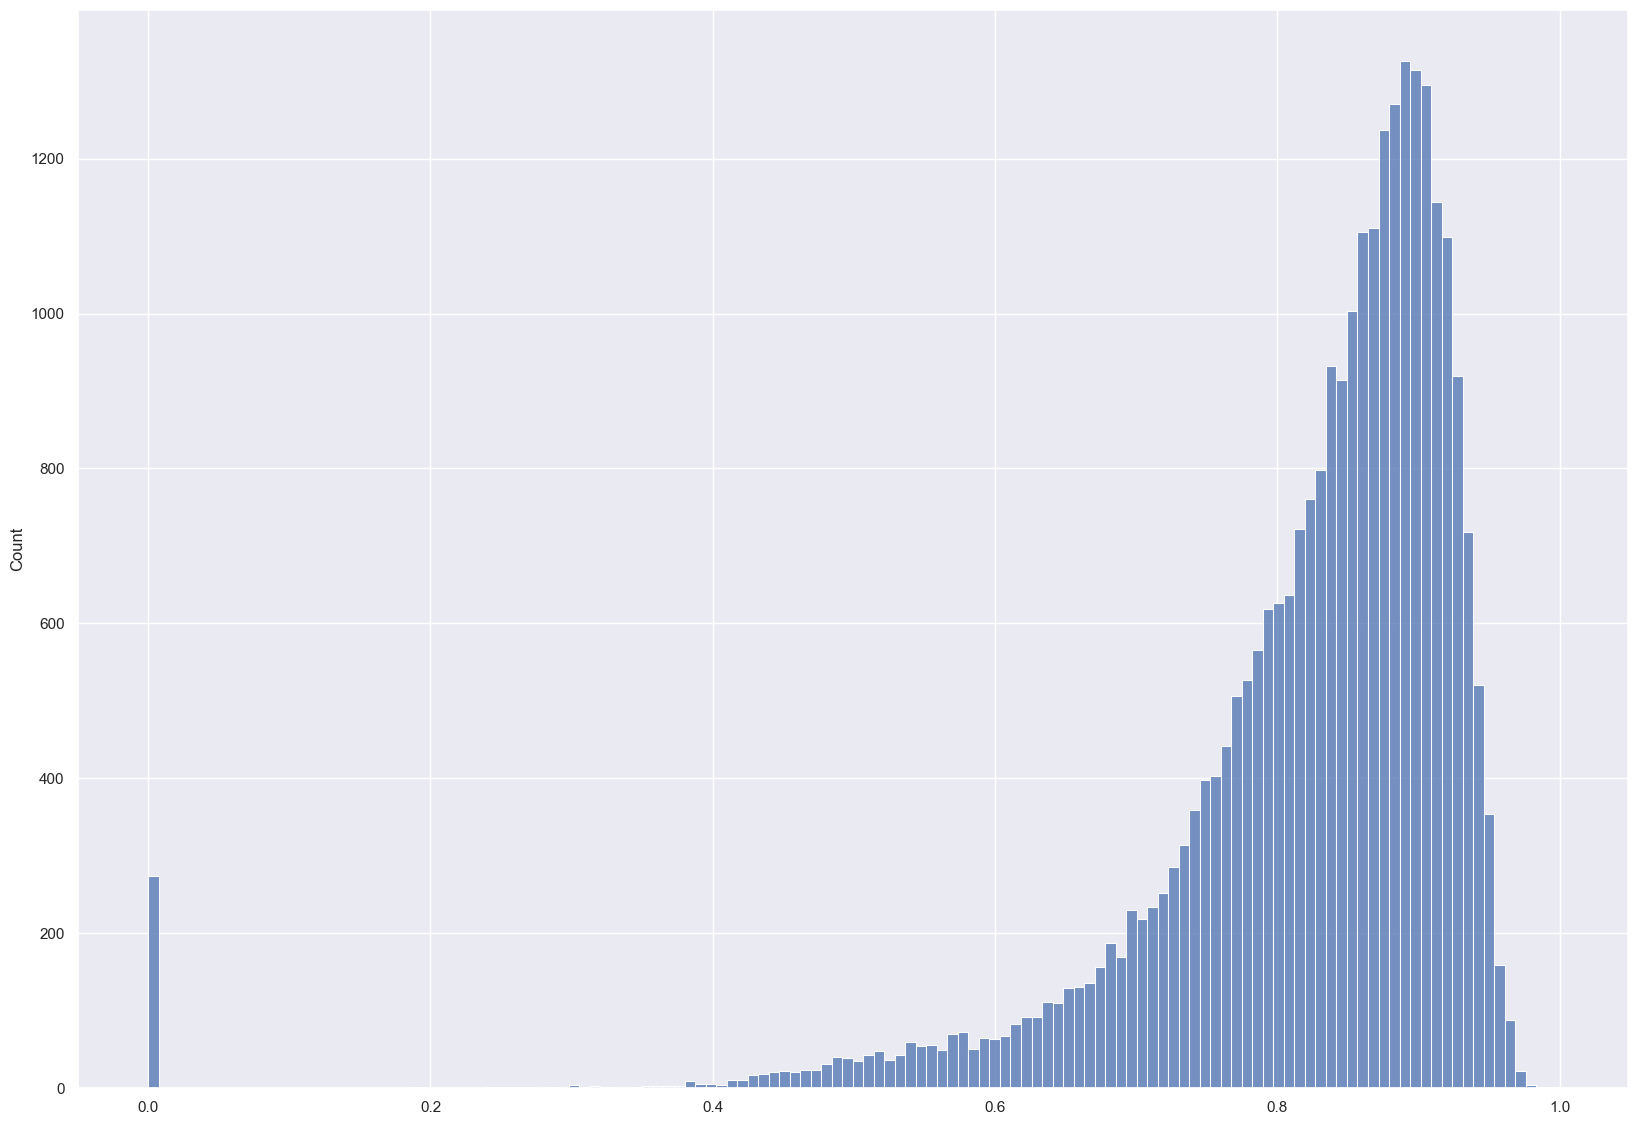

In [7]:
flat_data = [j for sub in Data for j in sub]
sns.histplot(flat_data)

Given the sizes of the original documents, we would like to see a distribution such that the number of high scoring matches is only as large as the smallest of sentences of the two documents.

## Third approach: compare the cosine similarity of individual words
This approach is taken from [this paper](https://www.fer.unizg.hr/_download/repository/TAR-2016-ProjectReports.pdf#page=10) (TODO: how to cite this properly?) and adapted to work with the spacy library.
> sentence similarity is computed through the cosine similarity between the
Word2Vec representations of individual words in the sentences

To do this, we use the library's [`Span.set_extension`](https://spacy.io/api/span#set_extension) class method to define our own way of computing the similarity of two sentences using the above algorithm.

In [9]:
from spacy.tokens import Span

def similarity_individual_words(self, span):
    '''Use the cosine similarity of individual words to compute a similarity score'''
    count = 0
    total = 0
    
    # Iterate over all tokens in the sentence, ignoring whitespace, punctuation, numbers, etc.
    self_words = [w for w in self if w.is_alpha]
    span_words = [w for w in span if w.is_alpha]
    
    for x in self_words:
        
        max_similarity = 0
        
        for y in span_words:
            
            similarity = x.similarity(y)
            
            if similarity > max_similarity:
                max_similarity = similarity
                
        if max_similarity > 0:
            count = count + 1
            total += max_similarity
    
    if count == 0:
        return 0
    
    return total/count


Span.set_extension("similarity_individual_words", method=similarity_individual_words, force=True)

Next we iterate over the sentences of the two documents, using the above extention to compute the similarity scores. This task takes some time so there's a progress bar added. TODO: add progress bas!

In [11]:
Data = []

# pairwise compare each sentence, populating the array with the scores
for i, a in enumerate(doc_egw.sents):
    Data.append([])
    
    for j, b in enumerate(doc_mel.sents):
        Data[i].append(a._.similarity_individual_words(b))

print(Data)

/var/folders/6h/4544kbh53s76rw63mxtngdmc0000gn/T/ipykernel_32162/3285948797.py:18: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity = x.similarity(y)


KeyboardInterrupt: 

## Further improvements
### Preprocessing the input
#### Checking for model support
It's not unusual the input text needs to be "cleaned", or preprocessed, before it is suitable for consumption by natural language processing libraries. There is no easy way to determine what preprocessing is needed; the text needs to be examined beforehand.

We can use the data already processed in the model to see if there are words that are not recognized by the model:

In [12]:
print(list(dict.fromkeys([x.text for x in doc_egw if x.is_alpha and not x.has_vector] 
                         + [x.text for x in doc_mel if x.is_alpha and not x.has_vector])))

['Cæsars', 'Nazarine', 'viler', 'slothfulness', 'setteth', 'apostolical', 'appertained', 'debauchee', 'efficaciousness', 'hinderances', 'circumstanced', 'recompences', 'whensoever', 'exigence', 'discountenanced', 'withdrawment', 'drudgeries', 'blamelessness', 'devotedness', 'obligingness', 'conciliates', 'hemitage', 'advantageousness', 'prayerfulness']


Preprocessing the input text to replace each of these words with a more common English equivalent would increase the number of words recognized by the model, resulting in more accurate similarity scores when comparing sentences containing the original words.

#### Removing stop words
We also try removing the *stop words*. See [this article](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a) to learn more about what stop words are, and about why we would want to remove from the text before processing.

Spacy has build-in stop word detection, and it is easy to adjust our modified similarity extension above to use this. The `Token` object has an `is_stop` attribute that we can use to filter out stop words while iterating over tokens in a sentence.

In [13]:
def similarity_individual_non_stop_words(self, span):
    '''Use the cosine similarity of individual words, ignoring stop words, to compute a similarity score'''
    count = 0
    total = 0
    
    # Iterate over all tokens in the sentence, ignoring whitespace, punctuation, numbers, stop words, etc.
    self_words = [w for w in self if w.is_alpha and not w.is_stop]
    span_words = [w for w in span if w.is_alpha and not w.is_stop]
    
    for x in self_words:
        
        max_similarity = 0
        
        for y in span_words:
            
            similarity = x.similarity(y)
            
            if similarity > max_similarity:
                max_similarity = similarity
                
        if max_similarity > 0:
            count = count + 1
            total += max_similarity
    
    if count == 0:
        return 0
    
    return total/count


Span.set_extension("similarity_individual_non_stop_words", method=similarity_individual_non_stop_words, force=True)